### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import country_converter as coco
import pycountry_convert as pc

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Gathering Data

In [2]:
from zipfile import ZipFile
with ZipFile("data/data-science-salaries-2023.zip","r") as zObject:
    zObject.extractall(path="data/")

In [3]:
import pandas as pd
import numpy as np
df_salary = pd.read_csv("data/ds_salaries.csv")
df_salary.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

## Data Exploration

In [4]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [5]:
df_salary.describe()

work_year        salary  salary_in_usd  remote_ratio
count  3755.000000  3.755000e+03    3755.000000   3755.000000
mean   2022.373635  1.906956e+05  137570.389880     46.271638
std       0.691448  6.716765e+05   63055.625278     48.589050
min    2020.000000  6.000000e+03    5132.000000      0.000000
25%    2022.000000  1.000000e+05   95000.000000      0.000000
50%    2022.000000  1.380000e+05  135000.000000      0.000000
75%    2023.000000  1.800000e+05  175000.000000    100.000000
max    2023.000000  3.040000e+07  450000.000000    100.000000

## Salary in USD

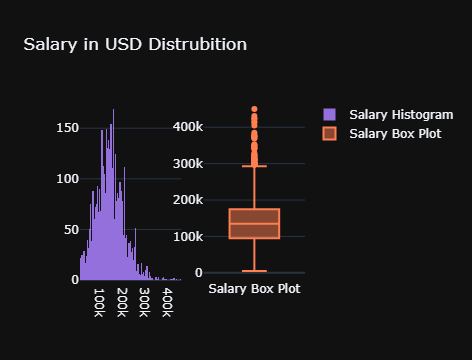

In [6]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(x=df_salary["salary_in_usd"] , name="Salary Histogram" , marker_color = "MediumPurple"), row=1 , col=1)
fig.add_trace(go.Box(y=df_salary["salary_in_usd"] , name="Salary Box Plot" , marker_color = "coral"), row=1 , col=2)
fig.update_layout(title_text = "Salary in USD Distrubition", template="plotly_dark")
fig.show()               

In [7]:
def find_outliers_IQR(df):
    q1= df.quantile(0.25)
    q3= df.quantile(0.75)
    IQR = q3-q1
    outliers = df[((df<(q1-1.5*IQR))| (df>(q3+1.5*IQR)))].index.tolist()
    print(outliers)
    print("Number of outliers: " , len(outliers))


In [8]:
find_outliers_IQR(df_salary["salary_in_usd"])


[33, 68, 83, 133, 145, 163, 190, 228, 358, 478, 482, 488, 528, 649, 687, 716, 793, 845, 860, 1007, 1097, 1099, 1105, 1116, 1131, 1153, 1258, 1286, 1288, 1311, 1396, 1421, 1427, 1458, 1558, 1593, 1605, 1675, 1677, 1722, 1932, 2011, 2162, 2279, 2281, 2331, 2359, 2374, 2406, 2502, 2555, 2670, 2832, 2856, 3152, 3410, 3463, 3468, 3522, 3675, 3697, 3747, 3750]
Number of outliers:  63


In [9]:
salary_in_usd = df_salary["salary_in_usd"]
print('Mean Salary in USD: ', salary_in_usd.values.mean())
print('Median Salary in USD: ', np.median (salary_in_usd.values))
print('Minimum Salary in USD: ', salary_in_usd.values.min())
print('Maximum Salary in USD: ', salary_in_usd.values.max())

Mean Salary in USD:  137570.38988015978
Median Salary in USD:  135000.0
Minimum Salary in USD:  5132
Maximum Salary in USD:  450000


## Work Year

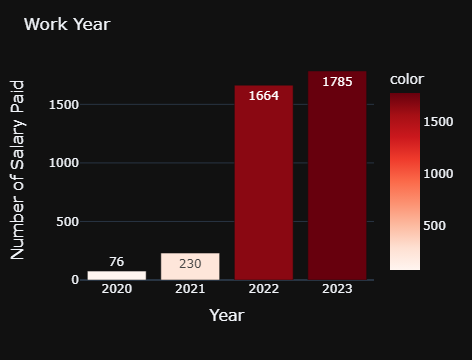

In [10]:
work_year_counts = df_salary["work_year"].value_counts().sort_index()
fig = px.bar(
            x=work_year_counts.index.astype('str'),
            y=work_year_counts.values,
            text=work_year_counts.values,
            color=work_year_counts.values,
            color_continuous_scale='Reds')
fig.update_layout(
    title='Work Year',
    xaxis=dict(
        title='Year',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Number of Salary Paid',
        titlefont_size=16
    ),
    template='plotly_dark',
)
fig.show()

## Experience Level

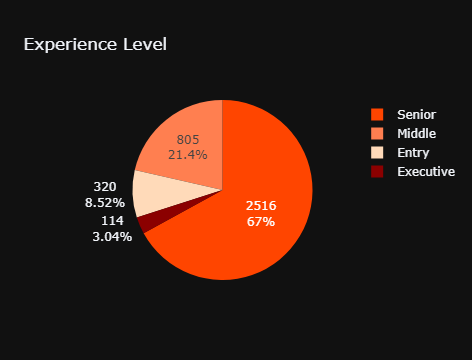

In [11]:
colors=["orangered", "coral", "peachpuff", "darkred"]

experience_level_counts = df_salary["experience_level"].value_counts()

fig = go.Figure(data = [go.Pie(
            values = experience_level_counts.values,
            labels = ['Senior', 'Middle', 'Entry', 'Executive'],
            textinfo='percent+value',
            marker_colors=colors)])
fig.update_layout(
        title_text='Experience Level',
        template='plotly_dark'
)
fig.show()

## Employment Type

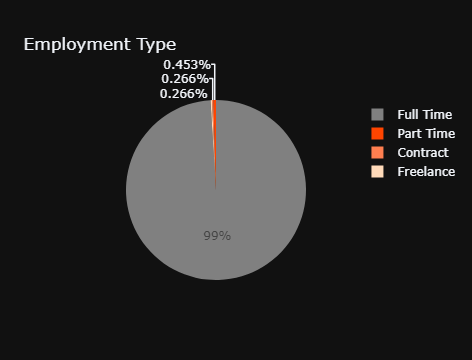

In [12]:
colors=['grey', 'orangered', 'coral', 'peachpuff']
employment_type_counts = df_salary['employment_type'].value_counts()
fig = px.pie (df_salary,
            values = employment_type_counts.values,
            names = ['Full Time', 'Part Time', 'Contract', 'Freelance'],
            title = 'Employment Type',
            color_discrete_sequence=colors)

fig.update_layout(
        template='plotly_dark'
)
fig.show()

## Job Title

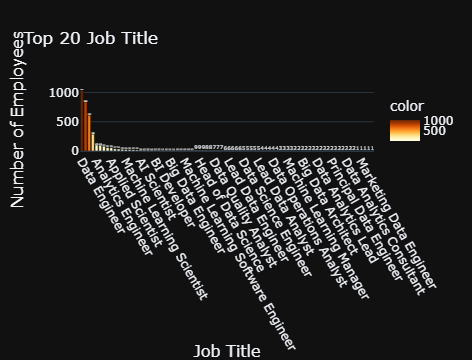

In [13]:
top20_job_title = df_salary['job_title'].value_counts().sort_values (ascending=False) [:80]
fig = px.bar(df_salary,
        x=top20_job_title.index,
        y=top20_job_title.values,
        text=top20_job_title.values,
        color=top20_job_title.values,
        color_continuous_scale='YlOrBr',
        title='Top 20 Job Title')

fig.update_layout(
        xaxis=dict(
            title='Job Title',
            titlefont_size=16
        ),
        yaxis=dict(
            title='Number of Employees',
            titlefont_size=16
        ),
        xaxis_tickangle=60,
        template='plotly_dark'
)

fig.update_traces (
        textfont_size=10
)
fig.show()

## Employee Residence

In [14]:
df_salary['employee_residence'] = coco.convert(df_salary['employee_residence'], to='ISO3')

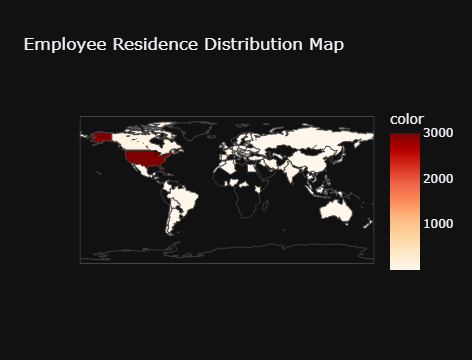

In [15]:
residence =df_salary['employee_residence'].value_counts()
fig = px.choropleth (locations=residence.index,
                     color = residence.values,
                     color_continuous_scale=px.colors.sequential.OrRd,
                     template='plotly_dark',
                     title='Employee Residence Distribution Map')	
fig.show()

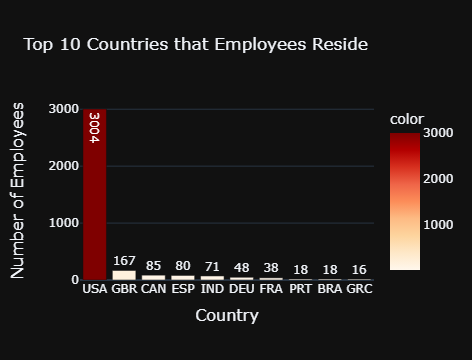

In [16]:
top10_residence = df_salary['employee_residence'].value_counts().sort_values (ascending=False) [:10]
fig = px.bar(df_salary,
            x=top10_residence.index,
            y=top10_residence.values,
            text=top10_residence.values,
            color=top10_residence.values,
            color_continuous_scale='OrRd',
            title='Top 10 Countries that Employees Reside')
fig.update_layout(
    xaxis=dict(
        title='Country',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Number of Employees',
        titlefont_size=16
    ),
    template='plotly_dark'
)

fig.update_traces (
        textfont_size=12
)
fig.show()

## Remote Ratio

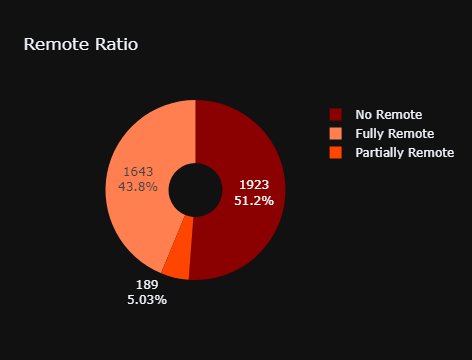

In [17]:
remote_ratio_counts = df_salary['remote_ratio'].value_counts()
colors=['darkred', 'coral' , 'orangered']

fig = go.Figure(data = [go.Pie(labels=['No Remote', 'Fully Remote', 'Partially Remote'],
                               values = remote_ratio_counts.values,
                               hole=.3,
                               textinfo='percent+value',
                               marker_colors=colors)])
fig.update_layout(
    title_text='Remote Ratio',
    template='plotly_dark'
)
fig.show()

## Company Location

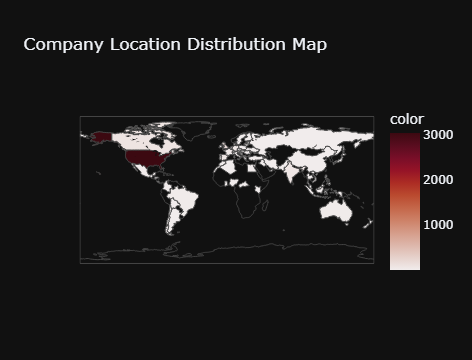

In [18]:
df_salary['company_location'] = coco.convert(df_salary['company_location'], to='ISO3')
company_location = df_salary['company_location'].value_counts()
fig = px.choropleth(locations=company_location.index,
                    color=company_location.values,
                    color_continuous_scale=px.colors.sequential.amp,
                    template='plotly_dark',
                    title='Company Location Distribution Map')

fig.show()

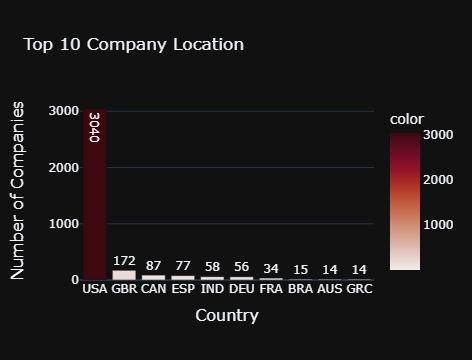

In [20]:
top10_company_location = df_salary['company_location'].value_counts()[:10]
fig = px.bar(df_salary, 
            x=top10_company_location.index, 
            y=top10_company_location.values,
            text=top10_company_location.values,
            color=top10_company_location.values,
            color_continuous_scale=px.colors.sequential.amp,
            title='Top 10 Company Location')
fig.update_layout(
    xaxis=dict(
        title='Country',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Number of Companies',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.update_traces(
    textfont_size=12
)
fig.show()

## Company Size

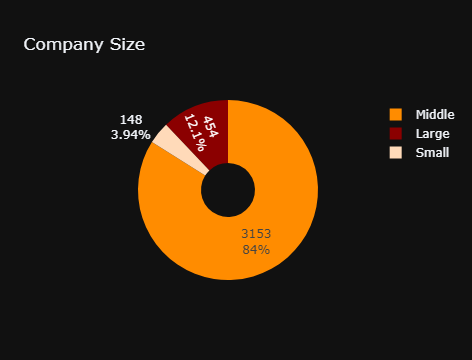

In [21]:
company_size_counts = df_salary['company_size'].value_counts()
colors=['darkorange', 'darkred', 'peachpuff']

fig = go.Figure(data=[go.Pie(labels=['Middle', 'Large', 'Small'],
                             values=company_size_counts.values,
                             hole=.3,
                             textinfo='percent+value',
                             marker_colors=colors)])
fig.update_layout(
    title_text='Company Size',
    template='plotly_dark'
)
fig.show()

## Work Year and Salary

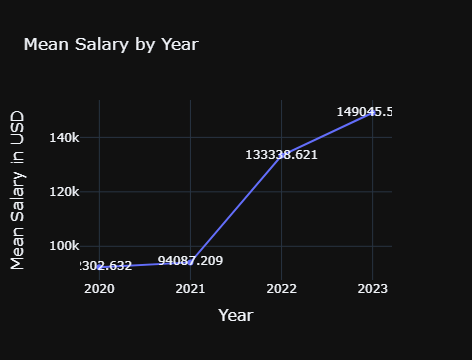

In [24]:
salary_by_year = df_salary.groupby('work_year')['salary_in_usd'].mean()

fig = px.line(df_salary,
            x=salary_by_year.index.astype('str'),
            y=salary_by_year.values,
            text=np.round(salary_by_year.values,3),
            title='Mean Salary by Year')
fig.update_layout(
    xaxis=dict(
        title='Year',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()

## Salary by Experience

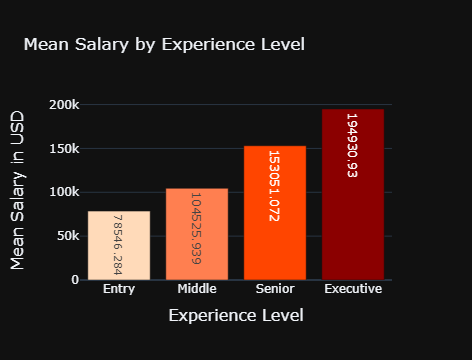

In [25]:
salary_by_experience = df_salary.groupby('experience_level')['salary_in_usd'].mean().sort_values(ascending=True)

colors=['peachpuff', 'coral', 'orangered', 'darkred']

fig = go.Figure(data=[go.Bar(
    x=['Entry', 'Middle', 'Senior', 'Executive'],
    y=salary_by_experience.values,
    text=np.round(salary_by_experience.values, 3),
    marker_color=colors
)])
fig.update_layout(
    title_text='Mean Salary by Experience Level',
    xaxis=dict(
        title='Experience Level',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()

## Employment Type and Salary

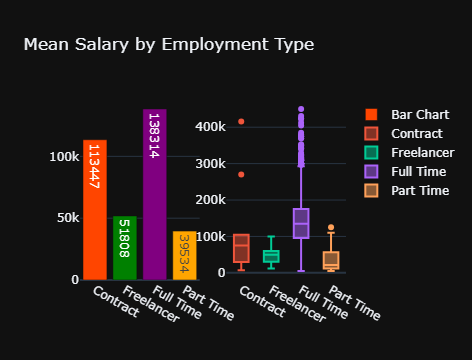

In [27]:
fig = make_subplots(rows=1, cols=2)

salary_by_type = df_salary.groupby('employment_type')['salary_in_usd'].mean()
salary_by_CT = df_salary.loc[df_salary['employment_type']=='CT']
salary_by_FL = df_salary.loc[df_salary['employment_type']=='FL']
salary_by_FT = df_salary.loc[df_salary['employment_type']=='FT']
salary_by_PT = df_salary.loc[df_salary['employment_type']=='PT']

colors=['orangered', 'green', 'purple', 'orange']

fig.add_trace(
    go.Bar(
        x=['Contract', 'Freelancer', 'Full Time', 'Part Time'], 
        y=salary_by_type.values, 
        name='Bar Chart',
        text=np.round(salary_by_type.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=salary_by_CT['salary_in_usd'], name='Contract'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salary_by_FL['salary_in_usd'], name='Freelancer'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salary_by_FT['salary_in_usd'], name='Full Time'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salary_by_PT['salary_in_usd'], name='Part Time'),
    row=1, col=2
)

fig.update_layout( 
    title_text="Mean Salary by Employment Type",
    template='plotly_dark')
fig.show()

## Salary by Job Title

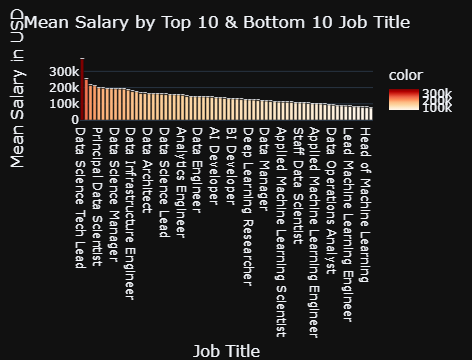

In [28]:
salary_by_title = df_salary.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)[:70]
#low10_salary_by_title = df_salaries.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)[-10:]
#salary_by_title = pd.concat([top10_salary_by_title, low10_salary_by_title])

fig = px.bar(
    df_salary,
    x=salary_by_title.index,
    y=salary_by_title.values,
    color=salary_by_title.values,
    color_continuous_scale='OrRd',
    text=np.round(salary_by_title.values)
)
fig.update_layout(
    title_text='Mean Salary by Top 10 & Bottom 10 Job Title',
    xaxis=dict(
        title='Job Title',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)

fig.update_traces(
    textfont_size=8
)

fig.show()

In [31]:
titles = salary_by_title.index.tolist()
salary_by_title_df = df_salary.loc[df_salary.apply(lambda x: x.job_title in titles, axis=1)]

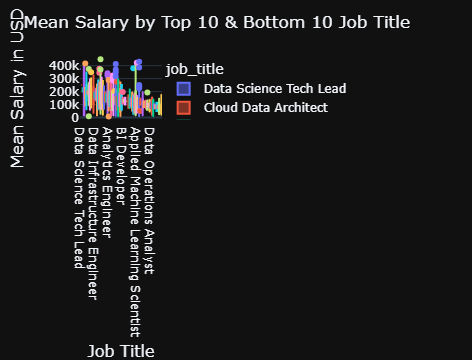

In [32]:
fig = px.box(salary_by_title_df, 
             x='job_title', 
             y='salary_in_usd', 
             color='job_title',
             category_orders={'job_title': titles})

fig.update_layout(
    title_text='Mean Salary by Top 10 & Bottom 10 Job Title',
    xaxis=dict(
        title='Job Title',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()


In [33]:
def process_job_title(df_salaries):
    i = 0
    for job_title in df_salaries["job_title"]:
        if ('Scientist' in job_title):
            df_salaries.at[i, 'job_title_classified'] = "Scientist"   
        elif ('Engineer' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Engineer'
        elif ('Analyst' in job_title or 'Strategist' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Analyst'
        elif ('Manager' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Manager'
        elif ('Developer' in job_title or 'Programmer' in job_title or 'Technician' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Developer'
        elif ('Architect' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Architect'
        elif ('Head' in job_title or 'Lead' in job_title or 'Director' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Lead'
        elif ('Researcher' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Researcher'
        elif ('Consultant' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Consultant'
        elif ('Specialist' in job_title):
            df_salaries.at[i, 'job_title_classified'] = 'Data Specialist'
        i=i+1
    return df_salaries

In [35]:
process_job_title(df_salary)

work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0       80000             EUR          85847                ESP           100   
1       30000             USD          30000                USA           100   
2       25500             USD          25500                USA           100   
3      175000             USD         175000                CAN           100   
4      120000             USD         120000                CAN           100   
...       ...             ...            ...                ...           ...   
3750   412000             USD         412000                USA           100   
3751   151000             USD         151000                USA           100   
3752   105000             USD         105000                USA           100   
3753   100000             USD         100000                USA           100   
3754  7000000             INR          94665                IND            50   

     company_location company_size job_title_classified  
0                 ESP            L            Scientist  
1                 USA            S        Data Engineer  
2                 USA            S        Data Engineer  
3                 CAN            M            Scientist  
4                 CAN            M            Scientist  
...               ...          ...                  ...  
3750              USA            L            Scientist  
3751              USA            L            Scientist  
3752              USA            S            Scientist  
3753              USA            L         Data Analyst  
3754              IND            L         Data Manager  

[3755 rows x 12 columns]

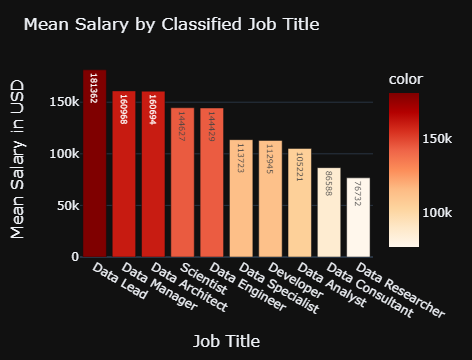

In [37]:
salary_by_title = df_salary.groupby('job_title_classified')['salary_in_usd'].mean().sort_values(ascending=False)

fig = px.bar(df_salary,
    x=salary_by_title.index,
    y=salary_by_title.values,
    color=salary_by_title.values,
    color_continuous_scale='OrRd',
    text=np.round(salary_by_title.values)
)
fig.update_layout(
    title_text='Mean Salary by Classified Job Title',
    xaxis=dict(
        title='Job Title',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.update_traces(
    textfont_size=8
)
fig.show()

In [40]:
classified_titles = salary_by_title.index.tolist()
salary_by_classified_title_df = df_salary.loc[df_salary.apply(lambda x: x.job_title_classified in classified_titles, axis=1)]

In [41]:
classified_titles

['Data Lead',
 'Data Manager',
 'Data Architect',
 'Scientist',
 'Data Engineer',
 'Data Specialist',
 'Developer',
 'Data Analyst',
 'Data Consultant',
 'Data Researcher']

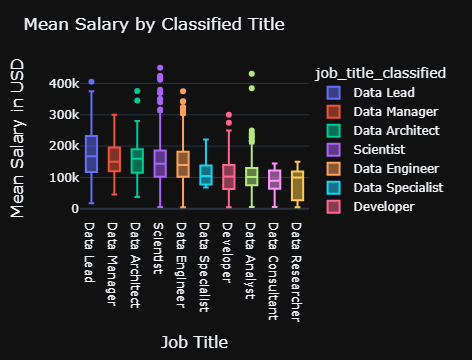

In [42]:
fig = px.box(salary_by_classified_title_df, 
             x='job_title_classified', 
             y='salary_in_usd', 
             color='job_title_classified',
             category_orders={'job_title_classified': classified_titles})

fig.update_layout(
    title_text='Mean Salary by Classified Title',
    xaxis=dict(
        title='Job Title',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()

## Employee Residence by Mean Salary

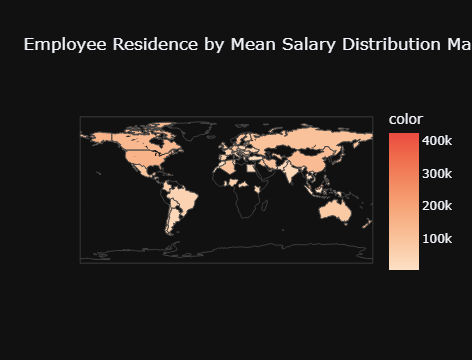

In [43]:
residence_by_salary = df_salary.groupby('employee_residence')['salary_in_usd'].mean()
fig = px.choropleth(locations=residence_by_salary.index,
                    color=residence_by_salary.values,
                    color_continuous_scale=px.colors.sequential.Peach,
                    template='plotly_dark',
                    title='Employee Residence by Mean Salary Distribution Map')

fig.show()

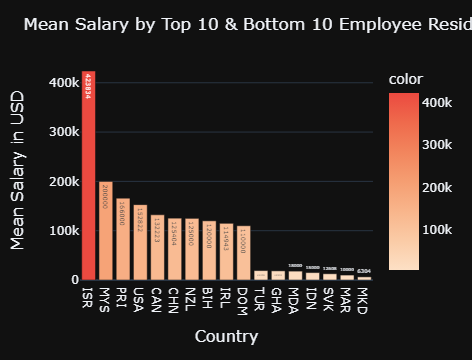

In [45]:
top10_salary_by_residence = df_salary.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False)[:10]
low10_salary_by_residence = df_salary.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False)[-7:]
salary_by_residence = pd.concat([top10_salary_by_residence, low10_salary_by_residence])

fig = px.bar(df_salary,
    x=salary_by_residence.index,
    y=salary_by_residence.values,
    color=salary_by_residence.values,
    color_continuous_scale='Peach',
    text=np.round(salary_by_residence.values)
)
fig.update_layout(
    title_text='Mean Salary by Top 10 & Bottom 10 Employee Residence',
    xaxis=dict(
        title='Country',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.update_traces(
    textfont_size=8
)
fig.show()

In [46]:
df_salary['employee_residence'] = coco.convert(names=df_salary['employee_residence'], to='ISO2')
df_salary['residence_continent'] = df_salary['employee_residence'].apply(lambda x: pc.country_alpha2_to_continent_code(x))

In [48]:
df_salary

work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0       80000             EUR          85847                 ES           100   
1       30000             USD          30000                 US           100   
2       25500             USD          25500                 US           100   
3      175000             USD         175000                 CA           100   
4      120000             USD         120000                 CA           100   
...       ...             ...            ...                ...           ...   
3750   412000             USD         412000                 US           100   
3751   151000             USD         151000                 US           100   
3752   105000             USD         105000                 US           100   
3753   100000             USD         100000                 US           100   
3754  7000000             INR          94665                 IN            50   

     company_location company_size job_title_classified residence_continent  
0                 ESP            L            Scientist                  EU  
1                 USA            S        Data Engineer                  NA  
2                 USA            S        Data Engineer                  NA  
3                 CAN            M            Scientist                  NA  
4                 CAN            M            Scientist                  NA  
...               ...          ...                  ...                 ...  
3750              USA            L            Scientist                  NA  
3751              USA            L            Scientist                  NA  
3752              USA            S            Scientist                  NA  
3753              USA            L         Data Analyst                  NA  
3754              IND            L         Data Manager                  AS  

[3755 rows x 13 columns]

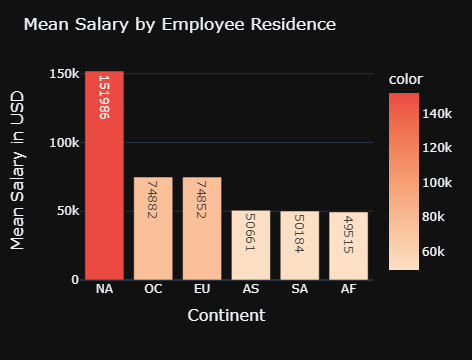

In [49]:
salary_by_residence_continent = df_salary.groupby('residence_continent')['salary_in_usd'].mean().sort_values(ascending=False)

fig = px.bar(df_salary,
    x=salary_by_residence_continent.index,
    y=salary_by_residence_continent.values,
    color=salary_by_residence_continent.values,
    color_continuous_scale='Peach',
    text=np.round(salary_by_residence_continent.values)
)
fig.update_layout(
    title_text='Mean Salary by Employee Residence',
    xaxis=dict(
        title='Continent',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()

## Remote Ratio and Salary

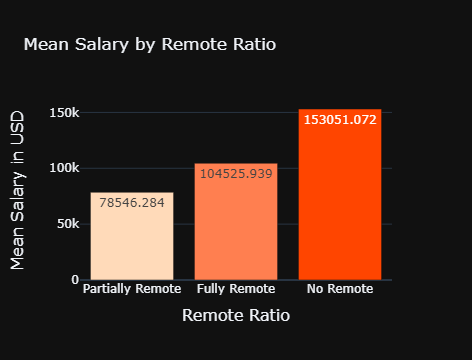

In [50]:
salary_by_remote = df_salary.groupby('remote_ratio')['salary_in_usd'].mean().sort_values(ascending=True)

colors=['peachpuff', 'coral', 'orangered']
fig = go.Figure(data=[go.Bar(
    x=['Partially Remote', 'Fully Remote', 'No Remote'],
    y=salary_by_experience.values,
    marker_color=colors,
    text=np.round(salary_by_experience.values,3)
)])
fig.update_layout(
    title_text='Mean Salary by Remote Ratio',
    xaxis=dict(
        title='Remote Ratio',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean Salary in USD',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()

## Company Size and Salary

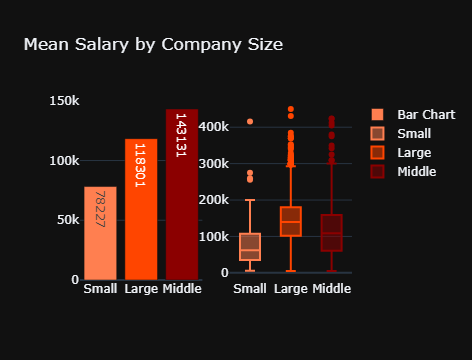

In [52]:
fig = make_subplots(rows=1, cols=2)

salary_by_company_size = df_salary.groupby('company_size')['salary_in_usd'].mean().sort_values(ascending=True)

salary_by_small = df_salary.loc[df_salary['company_size']=='S']
salary_by_middle = df_salary.loc[df_salary['company_size']=='M']
salary_by_large = df_salary.loc[df_salary['company_size']=='L']

colors=['coral', 'orangered', 'darkred']

fig.add_trace(
    go.Bar(
        x=['Small', 'Large', 'Middle'],
        y=salary_by_company_size.values, 
        name='Bar Chart',
        marker_color=colors,
        text=np.round(salary_by_company_size.values)),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=salary_by_small['salary_in_usd'], name='Small', marker_color='coral'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salary_by_middle['salary_in_usd'], name='Large', marker_color='orangered'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salary_by_large['salary_in_usd'], name='Middle', marker_color='darkred'),
    row=1, col=2
)

fig.update_layout(title_text="Mean Salary by Company Size", template='plotly_dark')
fig.show()

## Modelling

## Descriptions of Predefined Functions
- evaluate: This function prints out RMSE given inputs model, X_train, X_test, y_train, and y_test.
- avg_rmse_cv: This function does 5 fold cross validation given input model to get more precise evaluation score.
- print_best_params: This function print out best optimized RMSE after 5 fold cross validation and best parameter given model and parameter grid.
- select_best_features: This function remove feature with feature importance less than or equal to zero, so it can return X features data frame with best features. This function is specifically for linear model.
- select_best_features_nonlinear: This function selects top 10 important features. This function is specifically for non-linear model.

In [53]:
rs_value = 156

In [54]:
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('###', model.__class__.__name__, '###')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('RMSE: {0: .5f}'.format(rmse))

In [55]:
def avg_rmse_cv(model):
    rmse_list = np.sqrt(-cross_val_score(model, X_features_ohe, log_y_target,
                                             scoring='neg_mean_squared_error', cv=5))
    rmse_avg = np.mean(rmse_list)
    print('{0} 5 Fold CV Average RMSE: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 5)))

In [56]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features_ohe, log_y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} Optimized RMSE after 5 Fold CV: {1}, Best Parameter: {2}'
          .format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [57]:
def select_best_features(model):
    remove_feature_lst = []
    coef = pd.Series(model.coef_, index=X_features_ohe.columns)
    for index, value in coef.items():
        if value <= 0: 
            remove_feature_lst.append(index)
    print('{0}: {1} features dropped'.format(model.__class__.__name__, len(remove_feature_lst)))
    X_best_features = X_features_ohe.drop(remove_feature_lst, axis=1, inplace=False)
    return X_best_features

In [58]:
def select_best_features_nonlinear(model):
    coef = pd.Series(model.feature_importances_, index=X_features_ohe.columns)
    remove_feature_lst = coef.sort_values(ascending=False)[10:].index
    X_best_features = X_features_ohe.drop(remove_feature_lst, axis=1, inplace=False)
    return X_best_features

In [59]:
df_salary

work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0       80000             EUR          85847                 ES           100   
1       30000             USD          30000                 US           100   
2       25500             USD          25500                 US           100   
3      175000             USD         175000                 CA           100   
4      120000             USD         120000                 CA           100   
...       ...             ...            ...                ...           ...   
3750   412000             USD         412000                 US           100   
3751   151000             USD         151000                 US           100   
3752   105000             USD         105000                 US           100   
3753   100000             USD         100000                 US           100   
3754  7000000             INR          94665                 IN            50   

     company_location company_size job_title_classified residence_continent  
0                 ESP            L            Scientist                  EU  
1                 USA            S        Data Engineer                  NA  
2                 USA            S        Data Engineer                  NA  
3                 CAN            M            Scientist                  NA  
4                 CAN            M            Scientist                  NA  
...               ...          ...                  ...                 ...  
3750              USA            L            Scientist                  NA  
3751              USA            L            Scientist                  NA  
3752              USA            S            Scientist                  NA  
3753              USA            L         Data Analyst                  NA  
3754              IND            L         Data Manager                  AS  

[3755 rows x 13 columns]

In [61]:
y_target = df_salary['salary_in_usd']
X_features = df_salary.drop(['salary_in_usd', 'salary', 'salary_currency', 'job_title', 'employee_residence', 'company_location'], axis=1, inplace=False)

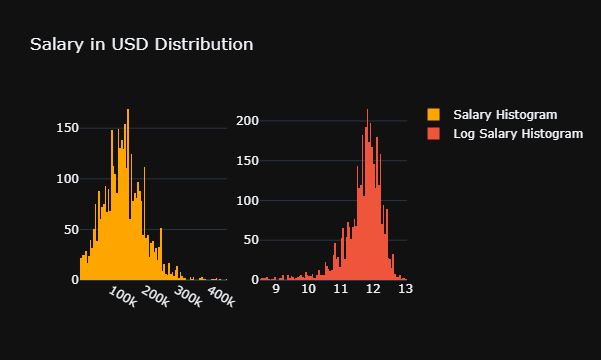

In [63]:
log_y_target = np.log1p(y_target)

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x=y_target, name='Salary Histogram', marker_color='Orange'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=log_y_target, name='Log Salary Histogram'),
    row=1, col=2
)

fig.update_layout(title_text="Salary in USD Distribution", template='plotly_dark')
fig.show()

In [64]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   work_year             3755 non-null   int64 
 1   experience_level      3755 non-null   object
 2   employment_type       3755 non-null   object
 3   remote_ratio          3755 non-null   int64 
 4   company_size          3755 non-null   object
 5   job_title_classified  3753 non-null   object
 6   residence_continent   3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


In [65]:
X_features_ohe = pd.get_dummies(X_features)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, log_y_target, test_size=0.3, random_state=156)

In [67]:
X_features_ohe_index = X_features_ohe.reset_index()
log_y_target_index = log_y_target.reset_index()
new_df = X_features_ohe_index.merge(log_y_target_index, how='left')

In [68]:
new_df.drop(['index'], axis=1, inplace=True)

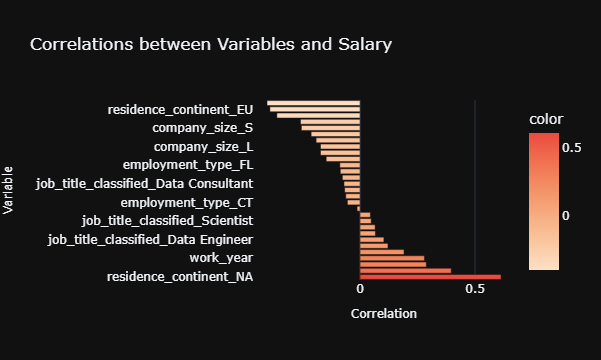

In [70]:
corr = new_df.corr()
correlations = corr['salary_in_usd'].sort_values(ascending=False)[1:]

fig = px.bar(df_salary, 
            x=correlations.values, 
            y=correlations.index, 
            color=correlations.values,
            color_continuous_scale='Peach',
            title='Correlations between Variables and Salary')
fig.update_layout(
    xaxis=dict(
        title='Correlation',
        titlefont_size=12
    ),
    yaxis=dict(
        title='Variable',
        titlefont_size=12
    ),
    template='plotly_dark'
)
fig.show()

In [74]:
new_df

work_year  remote_ratio  experience_level_EN  experience_level_EX  \
0          2023           100                False                False   
1          2023           100                False                False   
2          2023           100                False                False   
3          2023           100                False                False   
4          2023           100                False                False   
...         ...           ...                  ...                  ...   
3750       2020           100                False                False   
3751       2021           100                False                False   
3752       2020           100                 True                False   
3753       2020           100                 True                False   
3754       2021            50                False                False   

      experience_level_MI  experience_level_SE  employment_type_CT  \
0                   False                 True               False   
1                    True                False                True   
2                    True                False                True   
3                   False                 True               False   
4                   False                 True               False   
...                   ...                  ...                 ...   
3750                False                 True               False   
3751                 True                False               False   
3752                False                False               False   
3753                False                False                True   
3754                False                 True               False   

      employment_type_FL  employment_type_FT  employment_type_PT  ...  \
0                  False                True               False  ...   
1                  False               False               False  ...   
2                  False               False               False  ...   
3                  False                True               False  ...   
4                  False                True               False  ...   
...                  ...                 ...                 ...  ...   
3750               False                True               False  ...   
3751               False                True               False  ...   
3752               False                True               False  ...   
3753               False               False               False  ...   
3754               False                True               False  ...   

      job_title_classified_Data Specialist  job_title_classified_Developer  \
0                                    False                           False   
1                                    False                           False   
2                                    False                           False   
3                                    False                           False   
4                                    False                           False   
...                                    ...                             ...   
3750                                 False                           False   
3751                                 False                           False   
3752                                 False                           False   
3753                                 False                           False   
3754                                 False                           False   

      job_title_classified_Scientist  residence_continent_AF  \
0                               True                   False   
1                              False                   False   
2                              False                   False   
3                               True                   False   
4                               True                   False   
...                              ...                     ...   
37

## Linear Regression

In [75]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

LinearRegression()

In [76]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [77]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [78]:
linear_models = [lr_reg, ridge_reg, lasso_reg]

In [79]:
for model in linear_models:
    evaluate(model, X_train, X_test, y_train, y_test)
    avg_rmse_cv(model)

### LinearRegression ###
RMSE:  0.42793
LinearRegression 5 Fold CV Average RMSE: 0.40848
### Ridge ###
RMSE:  0.42793
Ridge 5 Fold CV Average RMSE: 0.40782
### Lasso ###
RMSE:  0.62431
Lasso 5 Fold CV Average RMSE: 0.59179


In [80]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index=X_features_ohe.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

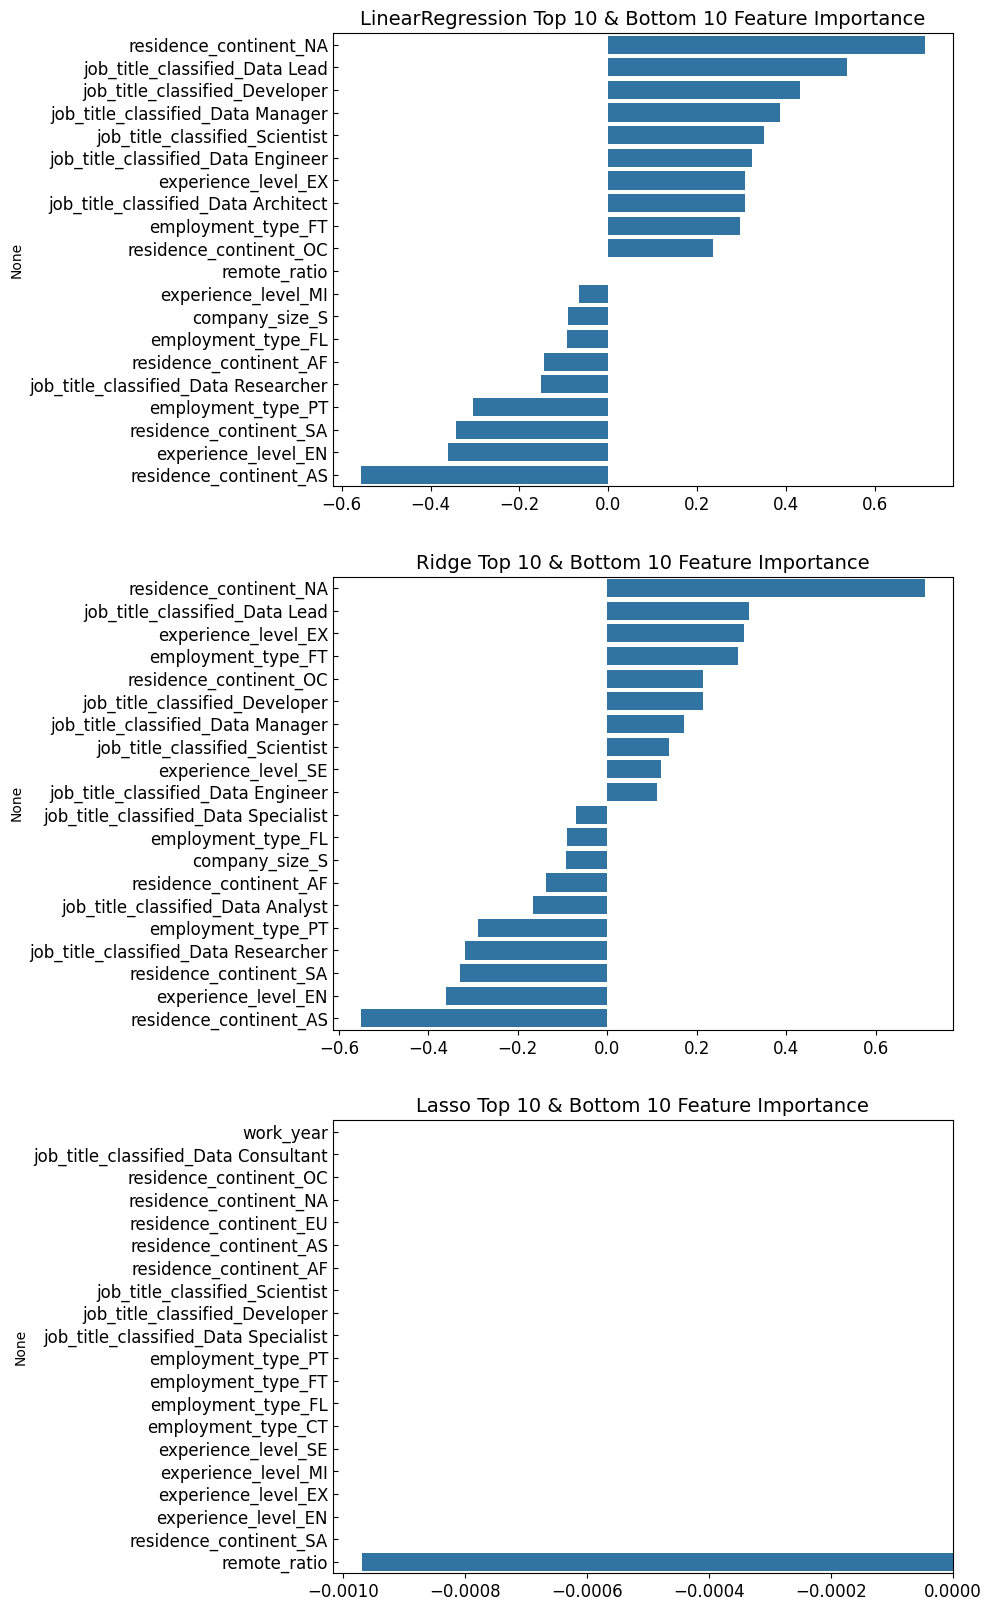

In [81]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(8, 20), nrows=3, ncols=1)
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__+' Top 10 & Bottom 10 Feature Importance', size=14)
        axs[i_num].tick_params(axis='y', direction='in')
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(12)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
visualize_coefficient(linear_models)

In [82]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
best_ridge = print_best_params(ridge_reg, ridge_params)

Ridge Optimized RMSE after 5 Fold CV: 0.4089, Best Parameter: {'alpha': 8}


### LinearRegression ###
RMSE:  0.42793
LinearRegression 5 Fold CV Average RMSE: 0.40848
### Ridge ###
RMSE:  0.42819
Ridge 5 Fold CV Average RMSE: 0.40696
### Lasso ###
RMSE:  0.42968
Lasso 5 Fold CV Average RMSE: 0.40827


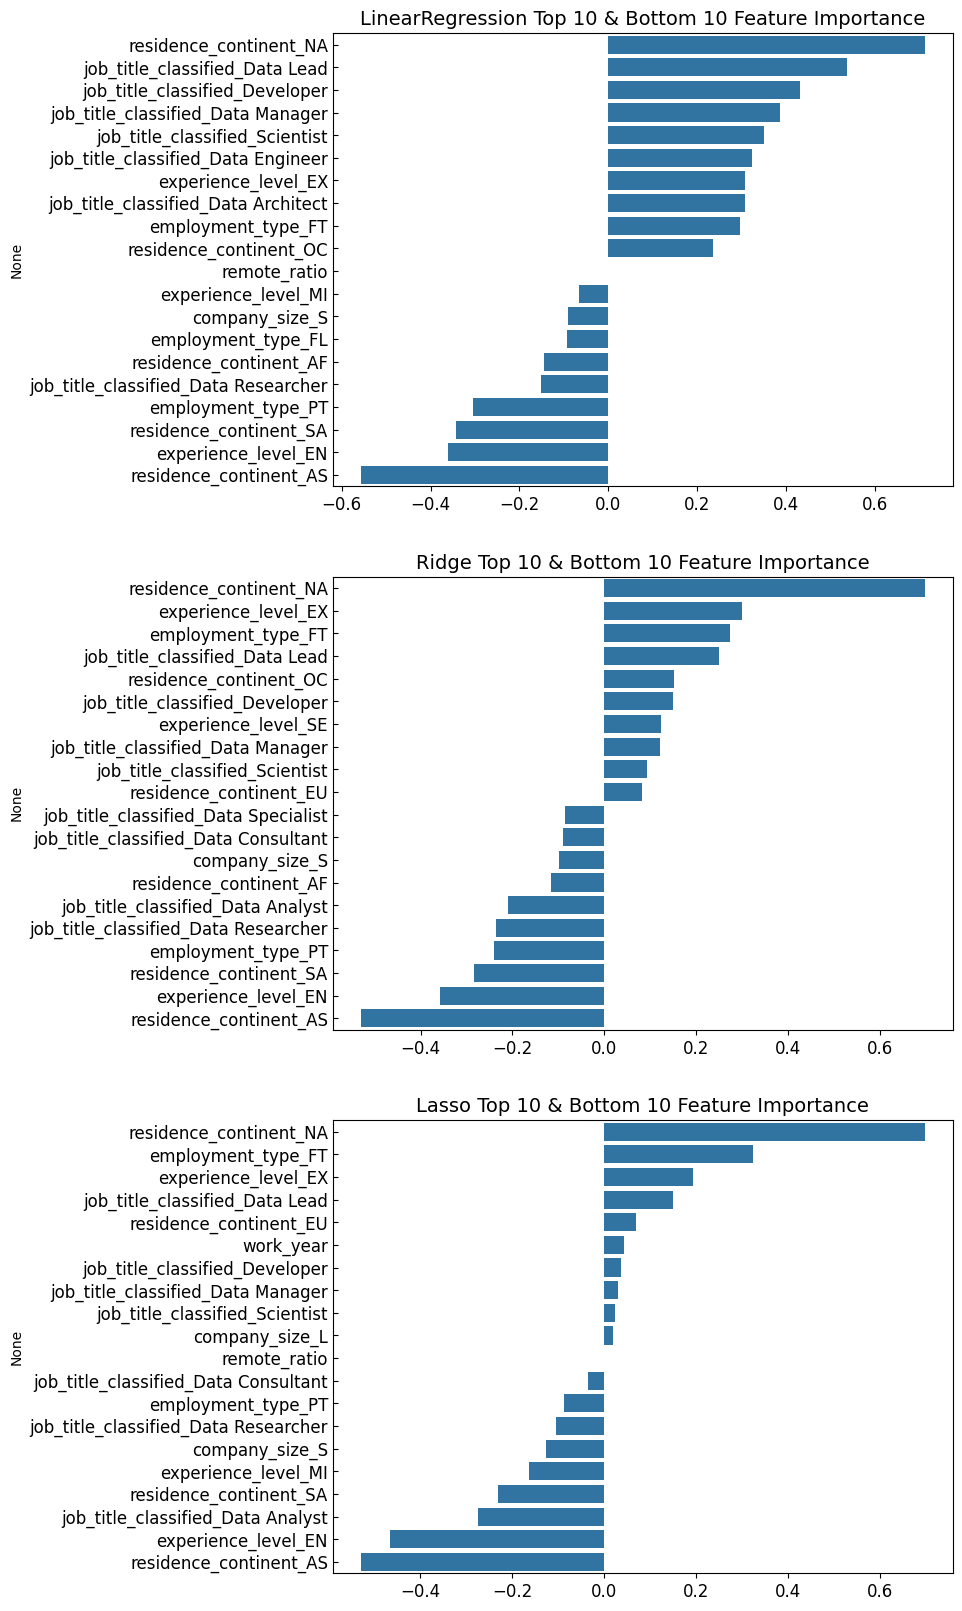

In [83]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

for model in models:
    evaluate(model, X_train, X_test, y_train, y_test)
    avg_rmse_cv(model)
    
visualize_coefficient(models)

In [84]:
lr_best_features = select_best_features(lr_reg)
X_train, X_test, y_train, y_test = train_test_split(lr_best_features, log_y_target, test_size=0.3, random_state=156)
evaluate(lr_reg, X_train, X_test, y_train, y_test)
avg_rmse_cv(lr_reg)

LinearRegression: 10 features dropped
### LinearRegression ###
RMSE:  0.42954
LinearRegression 5 Fold CV Average RMSE: 0.40848


In [85]:
ridge_best_features = select_best_features(ridge_reg)
X_train, X_test, y_train, y_test = train_test_split(ridge_best_features, log_y_target, test_size=0.3, random_state=156)
evaluate(ridge_reg, X_train, X_test, y_train, y_test)
avg_rmse_cv(ridge_reg)

Ridge: 13 features dropped
### Ridge ###
RMSE:  0.42965
Ridge 5 Fold CV Average RMSE: 0.40696


In [86]:
lasso_best_features = select_best_features(lasso_reg)
X_train, X_test, y_train, y_test = train_test_split(lasso_best_features, log_y_target, test_size=0.3, random_state=156)
evaluate(lasso_reg, X_train, X_test, y_train, y_test)
avg_rmse_cv(lasso_reg)

Lasso: 18 features dropped
### Lasso ###
RMSE:  0.44492
Lasso 5 Fold CV Average RMSE: 0.40827


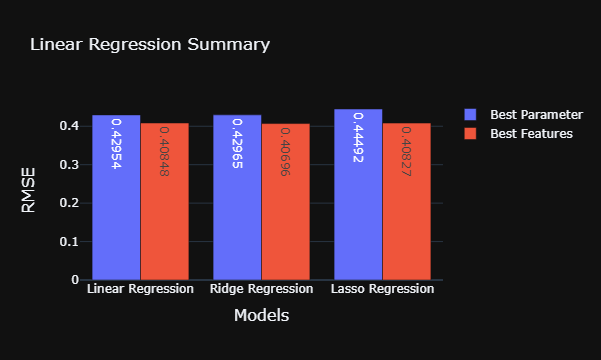

In [87]:
lr_models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
fig = go.Figure(data=[
    go.Bar(name='Best Parameter', x=lr_models, y=[0.42954, 0.42965, 0.44492], text=[0.42954, 0.42965, 0.44492]),
    go.Bar(name='Best Features', x=lr_models, y=[0.40848, 0.40696, 0.40827], text=[0.40848, 0.40696, 0.40827])
])
fig.update_layout(
    title_text='Linear Regression Summary',
    barmode='group',
    xaxis=dict(
        title='Models',
        titlefont_size=16
    ),
    yaxis=dict(
        title='RMSE',
        titlefont_size=16
    ),
    template='plotly_dark'
)
fig.show()